<a href="https://colab.research.google.com/github/Mubasshir-Ali/Deep_Learning_Practice/blob/master/NLP_Optimizing_The_Text_Generation_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimizing The Text Generation Model

You've already done some amazing work with generating new songs, but so far we've seen some issues with repetition and a fair amount of incoherence. By using more data and further tweaking the model, you'll be able to get improved results. We'll once again use the Kaggle Song Lyrics Dataset here.

# Import TensorFlow And Related Functions

In [0]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Other imports for processing data
import string
import pandas as pd
import numpy as np

# Get The Dataset
As noted above, we'll utilize the Song Lyrics dataset on Kaggle.

In [2]:
!wget --no-check-certificate \
    https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8 \
    -O /tmp/songdata.csv

--2020-05-09 06:55:56--  https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8
Resolving drive.google.com (drive.google.com)... 74.125.130.138, 74.125.130.101, 74.125.130.100, ...
Connecting to drive.google.com (drive.google.com)|74.125.130.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9j45bhnscmg0m14olcjdkbtm6uf6ncp1/1589007300000/11118900490791463723/*/1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8 [following]
--2020-05-09 06:55:59--  https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/9j45bhnscmg0m14olcjdkbtm6uf6ncp1/1589007300000/11118900490791463723/*/1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8
Resolving doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.googleusercontent.com)... 74.125.200.132, 2404:6800:4003:c00::84
Connecting to doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.googleusercontent.com)|74.125

# First 250 Songs
Now we've seen a model trained on just a small sample of songs, and how this often leads to repetition as you get further along in trying to generate new text. Let's switch to using the 250 songs instead, and see if our output improves. This will actually be nearly 10K lines of lyrics, which should be sufficient.

Note that we won't use the full dataset here as it will take up quite a bit of RAM and processing time, but you're welcome to try doing so on your own later. If interested, you'll likely want to use only some of the more common words for the Tokenizer, which will help shrink processing time and memory needed (or else you'd have an output array hundreds of thousands of words long).

# Preprocessing

In [0]:
def tokenize_corpus(corpus, num_words=-1):
  # Fit a Tokenizer on the corpus
  if num_words > -1:
    tokenizer = Tokenizer(num_words=num_words)
  else:
    tokenizer = Tokenizer()
  tokenizer.fit_on_texts(corpus)
  return tokenizer

def create_lyrics_corpus(dataset, field):
  # Remove all other punctuation
  dataset[field] = dataset[field].str.replace('[{}]'.format(string.punctuation), '')
  # Make it lowercase
  dataset[field] = dataset[field].str.lower()
  # Make it one long string to split by line
  lyrics = dataset[field].str.cat()
  corpus = lyrics.split('\n')
  # Remove any trailing whitespace
  for l in range(len(corpus)):
    corpus[l] = corpus[l].rstrip()
  # Remove any empty lines
  corpus = [l for l in corpus if l != '']

  return corpus

In [4]:
def tokenize_corpus(corpus, num_words=-1):
  # Fit a Tokenizer on the corpus
  if num_words > -1:
    tokenizer = Tokenizer(num_words=num_words)
  else:
    tokenizer = Tokenizer()
  tokenizer.fit_on_texts(corpus)
  return tokenizer

# Read the dataset from csv - this time with 250 songs
dataset = pd.read_csv('/tmp/songdata.csv', dtype=str)[:250]
# Create the corpus using the 'text' column containing lyrics
corpus = create_lyrics_corpus(dataset, 'text')
# Tokenize the corpus
tokenizer = tokenize_corpus(corpus, num_words=2000)
total_words = tokenizer.num_words

# There should be a lot more words now
print(total_words)

2000


# Create Sequences and Labels
After preprocessing, we next need to create sequences and labels. Creating the sequences themselves is similar to before with texts_to_sequences, but also including the use of N-Grams; creating the labels will now utilize those sequences as well as utilize one-hot encoding over all potential output words.

In [0]:
sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		sequences.append(n_gram_sequence)

# Pad sequences for equal input length 
max_sequence_len = max([len(seq) for seq in sequences])
sequences = np.array(pad_sequences(sequences, maxlen=max_sequence_len, padding='pre'))

# Split sequences between the "input" sequence and "output" predicted word
input_sequences, labels = sequences[:,:-1], sequences[:,-1]
# One-hot encode the labels
one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [6]:
# Check out how some of our data is being stored
# The Tokenizer has just a single index per word
print(tokenizer.word_index['know'])
print(tokenizer.word_index['feeling'])
# Input sequences will have multiple indexes
print(input_sequences[5])
print(input_sequences[6])
# And the one hot labels will be as long as the full spread of tokenized words
print(one_hot_labels[5])
print(one_hot_labels[6])

31
158
[  0   0   0   0   0   0   0   0   0   0   0   0   0 111  66  86 206  29
   4]
[   0    0    0    0    0    0    0    0    0    0    0    0  111   66
   86  206   29    4 1196]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


# Train A (Better) Text Generation Model
With more data, we'll cut off after 100 epochs to avoid keeping you here all day. You'll also want to change your runtime type to GPU if you haven't already (you'll need to re-run the above cells if you change runtimes).

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

model = Sequential()
model.add(Embedding(total_words, 64, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(20)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(input_sequences, one_hot_labels, epochs=100, verbose=1)

Epoch 1/100
1480/1480 [==============================] - 12s 8ms/step - loss: 5.9860 - accuracy: 0.0462
Epoch 2/100
1480/1480 [==============================] - 12s 8ms/step - loss: 5.6738 - accuracy: 0.0523
Epoch 3/100
1480/1480 [==============================] - 12s 8ms/step - loss: 5.4550 - accuracy: 0.0742
Epoch 4/100
1480/1480 [==============================] - 12s 8ms/step - loss: 5.2717 - accuracy: 0.1027
Epoch 5/100
1480/1480 [==============================] - 12s 8ms/step - loss: 5.1095 - accuracy: 0.1251
Epoch 6/100
1480/1480 [==============================] - 13s 9ms/step - loss: 4.9665 - accuracy: 0.1369
Epoch 7/100
1480/1480 [==============================] - 12s 8ms/step - loss: 4.8071 - accuracy: 0.1493
Epoch 8/100
1480/1480 [==============================] - 12s 8ms/step - loss: 4.6433 - accuracy: 0.1641
Epoch 9/100
1480/1480 [==============================] - 12s 8ms/step - loss: 4.4955 - accuracy: 0.1794
Epoch 10/100
1480/1480 [==============================] - 12s 8m

# View The Training Graph

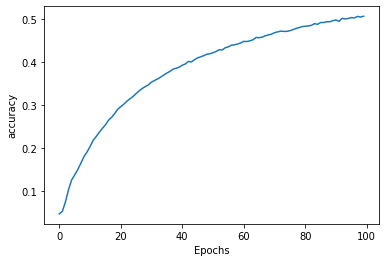

In [8]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

plot_graphs(history, 'accuracy')

# Generate Better Lyrics!
This time around, we should be able to get a more interesting output with less repetition.

In [9]:
seed_text = "im feeling chills"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = np.argmax(model.predict(token_list), axis=-1)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

im feeling chills me to the farm with a movie star the morning goes down honey rainy bless you die win slack cryin twist twist twist twist twist son gain kissed beat posses famous twist twist twist son wish wish buddy girlya forgot foolish clothes somebodys tone pain understand heal to whom to jive depressed to go down there and holding once me light me yonder get it thru so hard upon ya dream is a merry lover beat looking for your other side of your heart choice diamond games seventeen distant wish urge apple held the pirouette gain above clothes messin awaited


# Varying The Possible Outputs
In running the above, you may notice that the same seed text will generate similar outputs. This is because the code is currently always choosing the top predicted class as the next word. What if you wanted more variance in the output?

Switching from model.predict_classes to model.predict_proba will get us all of the class probabilities. We can combine this with np.random.choice to select a given predicted output based on a probability, thereby giving a bit more randomness to our outputs.

In [10]:
# Test the method with just the first word after the seed text
seed_text = "im feeling chills"
next_words = 100
  
token_list = tokenizer.texts_to_sequences([seed_text])[0]
token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
predicted_probs = model.predict(token_list)[0]
predicted = np.random.choice([x for x in range(len(predicted_probs))], 
                             p=predicted_probs)
# Running this cell multiple times should get you some variance in output
print(predicted)

7


In [11]:
# Use this process for the full output generation
seed_text = "im feeling chills"
next_words = 100
  
for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
  predicted_probs = model.predict(token_list)[0]
  predicted = np.random.choice([x for x in range(len(predicted_probs))],
                               p=predicted_probs)
  output_word = ""
  for word, index in tokenizer.word_index.items():
    if index == predicted:
      output_word = word
      break
  seed_text += " " + output_word
print(seed_text)

im feeling chills me it aint fair high why wrong in the lips very sunny first side smile money way know when his through the ground of rock of sucker tongue roll held beat trip arbuckle feeds pack pack win winner toys winner laid mornin fernando fernando today down me my happiest visitors going to me go low down through trial full circle colors above me he mean they come home sit shining his dust away let my smile for me to my angel whos going movin on me to control go away he mighty disguise just how nothing has how depressed we
